In [237]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import fasttext as ft

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
from utilities import regex_utility as reutil
import features_utility as featutil

import nltk

## File Details - Light GBM Regression NLP

First File on looking at doing NLP on the Beer name and text features. Investigate using fast text, because fast!
This file might start off with just the beer name, then we will go from there.

This file works, next file will refactor to make functions out of text preprocessing, language model and coverting to doc vectors in order to reuse for the review cols

Characteristics:
* Light GBM Regression Algorithm
* Start working on NLP on the Beer name text columns


In [238]:
filePrefix = "A3_120_lgbm_nlp_tinker"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
featuresDataDir = "features/"
writeSubRunFile = True
seed = databasic.get_random_seed()

In [239]:
# trainFilePath = baseDataDir + 'train.tsv'
# valiFilePath = baseDataDir + 'val.tsv'
# featuresFilePath = baseDataDir + 'features.tsv'
# testFilePath = baseDataDir + 'test.tsv'

trainFilePath = baseDataDir + 'train_200k.tsv'
valiFilePath = baseDataDir + 'vali_200k.tsv'
featuresFilePath = baseDataDir + 'features_200k.tsv'
testFilePath = baseDataDir + 'test_200k.tsv'

In [240]:
df_train = pd.read_csv(trainFilePath, sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])

df_vali = pd.read_csv(valiFilePath, sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])


df_test = pd.read_csv(testFilePath, sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])                                

print(df_train.shape)

(120564, 6)


In [241]:
# # RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
# # df_features = pd.read_csv(baseDataDir + 'features_500k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
# df_features = pd.read_csv(baseDataDir + 'features_200k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
#                                                                  'DayofMonth','Year','TimeOfDay','Gender',
#                                                                  'Birthday','Text','Lemmatized','POS_Tag'])

# df_features.head()

# colsToUse = ["RowID", "BrewerID", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"]

# # Find the feature records that match the training and validation data and join them together
# dfFullData = df_train.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
# dfFullDataVali = df_vali.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")

# dfFullData.head()

# # Remove the duplicated Row ID, also remove Beer Name at this point, we're nt using it
# df_train_data = dfFullData.drop(['RowIDFeat', "BeerName"],axis=1)
# df_vali_data = dfFullDataVali.drop(['RowIDFeat', "BeerName"],axis=1)

# df_train_data.head()

Let's just look at Beer name first. Compile a full list of the beer names, save it to file with one per line. Then we can load it with fasttext and build a language model

In [242]:
colName = "BeerName"

df_combined = df_train[["RowID", colName]].append(df_vali[["RowID", colName]]).append(df_test[["RowID", colName]])

# Remove ascii encoding
df_combined[colName] = df_combined.apply(lambda x: x[colName].encode("ascii", "ignore").decode(), axis=1)

# Remove punctuation
df_combined[colName] = df_combined.apply(lambda x: reutil.str_strip_punctuation(x[colName]), axis=1)

print(df_combined.shape)
df_combined.sort_values("RowID").head()


(199998, 2)


,RowID,BeerName
0,18,Rauch r Bock
0,19,Rauch r Bock
1,20,Rauch r Bock
1,21,Rauch r Bock
0,22,Rauch r Bock


Now tokenise every name and do some more processing

In [243]:
lstTokens = df_combined.apply(lambda x: x[colName].split(" "), axis=1)
lstTokens = lstTokens.to_list()

# remove capitalisation
lstTokens = list(map(lambda x: list(map(lambda y: y.lower(), x)), lstTokens))

# Remove single letter tokens
lstTokens = list(map(lambda x: list(filter(lambda y: len(y) >= 2, x)), lstTokens))

# Create variables for the words and vocab. When we update out tokens lists, we will want to recompile our word list and vocabulary to keep it up to date
words, vocab = databasic.createWordsAndVocabForTokenLists(lstTokens)

# Create a term Frequency distribution
term_fd = nltk.FreqDist(words)

# remove single occurrence words
setSingleWords = set(term_fd.hapaxes())
lstSingleWords = sorted(list(setSingleWords))
lstTokens = list(map(lambda x: databasic.filter_by_words_bsearch(x, lstSingleWords), lstTokens))

# Look at the most common words, but don't remove any in the end
# setMostFreqWords = term_fd.most_common(50)
# setMostFreqWords

In [244]:
# Replace original column with the cleaned data, then write it the names to file
df_combined[colName] = list(map(lambda x: ' '.join(x), lstTokens))
df_combined[[colName]].to_csv(featuresDataDir + filePrefix + "_" + colName + "_all.txt", index=0, header=False)  

df_combined.head(10)

,RowID,BeerName
0,19,rauch bock
1,21,rauch bock
2,23,rauch bock
3,24,rauch bock
4,25,rauch bock
5,26,rauch bock
6,29,rauch bock
7,31,rauch bock
8,32,rauch bock
9,33,rauch bock


Now replace the names in the original datasets

In [245]:
del df_train["BeerName"]
del df_vali["BeerName"]
del df_test["BeerName"]

df_train = pd.merge(df_train, df_combined, on="RowID")
df_vali = pd.merge(df_vali, df_combined, on="RowID")
df_test = pd.merge(df_test, df_combined, on="RowID")

In [246]:
del df_combined

Now train a Fast Text language model

In [247]:
fasttext_model = ft.train_unsupervised(featuresDataDir + filePrefix + "_" + colName + "_all.txt", dim=100)

print(fasttext_model.words[0:50])

# examine some of the word vectors
# print(fasttext_model.get_word_vector("stout"))

['</s>', 'ale', 'stout', 'nevada', 'sierra', 'founders', 'pale', 'ipa', 'imperial', 'hop', 'porter', 'lager', 'beer', 'india', 'double', 'style', 'aged', 'red', 'black', 'alesmith', 'brown', 'harvest', 'old', 'breakfast', 'rye', 'stoudts', 'of', 'wheat', 'green', 'extra', 'flash', 'anniversary', 'series', 'oatmeal', 'amber', 'sweetwater', 'belgian', 'barleywine', 'yeti', 'celebration', 'barrel', 'faith', 'lips', 'oak', 'winter', 'saison', 'de', 'hemisphere', 'dundee', 'bigfoot']


In [248]:
df_train_data = df_train
df_vali_data = df_vali
df_test_data = df_test

print(df_train_data.shape)
print(df_vali_data.shape)

df_train_data.head()

(120564, 6)
(39509, 6)


,RowID,BeerID,ReviewerID,BeerType,rating,BeerName
0,19,12300,10635,Rauchbier,4.0,rauch bock
1,21,12300,6547,Rauchbier,4.5,rauch bock
2,23,12300,9789,Rauchbier,4.5,rauch bock
3,24,12300,7372,Rauchbier,5.0,rauch bock
4,25,12300,1302,Rauchbier,4.5,rauch bock


In [249]:
# Create a new dataframe that just the Ids, rating and document vectors, but at columns

train_doc_vectors = list(map(lambda x: fasttext_model.get_sentence_vector(x), df_train_data[colName]))
vali_doc_vectors = list(map(lambda x: fasttext_model.get_sentence_vector(x), df_vali_data[colName]))
test_doc_vectors = list(map(lambda x: fasttext_model.get_sentence_vector(x), df_test_data[colName]))

df_train_doc_vectors = pd.DataFrame(train_doc_vectors)
df_vali_doc_vectors = pd.DataFrame(vali_doc_vectors)
df_test_doc_vectors = pd.DataFrame(test_doc_vectors)

# doc_vectors
print(type(df_train_doc_vectors))
df_train_doc_vectors.head()

In [ ]:
df_train_doc_vectors.columns = list(map(lambda x: colName + "_DocVec_" + str(x), df_train_doc_vectors.columns))
df_vali_doc_vectors.columns = list(map(lambda x: colName + "_DocVec_" + str(x), df_vali_doc_vectors.columns))
df_test_doc_vectors.columns = list(map(lambda x: colName + "_DocVec_" + str(x), df_test_doc_vectors.columns))

df_vali_doc_vectors.head()

,BeerName_DocVec_0,BeerName_DocVec_1,BeerName_DocVec_2,BeerName_DocVec_3,BeerName_DocVec_4,BeerName_DocVec_5,BeerName_DocVec_6,BeerName_DocVec_7,BeerName_DocVec_8,BeerName_DocVec_9,...,BeerName_DocVec_90,BeerName_DocVec_91,BeerName_DocVec_92,BeerName_DocVec_93,BeerName_DocVec_94,BeerName_DocVec_95,BeerName_DocVec_96,BeerName_DocVec_97,BeerName_DocVec_98,BeerName_DocVec_99
0,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
1,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
2,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
3,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
4,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366


In [ ]:
df_train_data = pd.concat([df_train_data[["RowID","BeerID","ReviewerID","rating"]], df_train_doc_vectors], axis=1)
df_vali_data = pd.concat([df_vali_data[["RowID","BeerID","ReviewerID","rating"]], df_vali_doc_vectors], axis=1)
df_test_data = pd.concat([df_test_data[["RowID","BeerID","ReviewerID","rating"]], df_test_doc_vectors], axis=1)
df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,BeerName_DocVec_0,BeerName_DocVec_1,BeerName_DocVec_2,BeerName_DocVec_3,BeerName_DocVec_4,BeerName_DocVec_5,...,BeerName_DocVec_90,BeerName_DocVec_91,BeerName_DocVec_92,BeerName_DocVec_93,BeerName_DocVec_94,BeerName_DocVec_95,BeerName_DocVec_96,BeerName_DocVec_97,BeerName_DocVec_98,BeerName_DocVec_99
0,22,12300,2634,4.0,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
1,27,12300,5634,4.5,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
2,28,12300,3544,4.5,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
3,40,12300,6521,4.0,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
4,43,12300,10177,4.5,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366


In [ ]:
df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,BeerName_DocVec_0,BeerName_DocVec_1,BeerName_DocVec_2,BeerName_DocVec_3,BeerName_DocVec_4,BeerName_DocVec_5,...,BeerName_DocVec_90,BeerName_DocVec_91,BeerName_DocVec_92,BeerName_DocVec_93,BeerName_DocVec_94,BeerName_DocVec_95,BeerName_DocVec_96,BeerName_DocVec_97,BeerName_DocVec_98,BeerName_DocVec_99
0,22,12300,2634,4.0,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
1,27,12300,5634,4.5,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
2,28,12300,3544,4.5,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
3,40,12300,6521,4.0,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
4,43,12300,10177,4.5,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366


In [ ]:
# free up the memory
del train_doc_vectors
del vali_doc_vectors
del test_doc_vectors
del df_train_doc_vectors
del df_vali_doc_vectors
del df_test_doc_vectors

In [ ]:
# Write test data to file, when we do a complete run. Otherwise, just drop the test data out of memory
del df_test
del df_test_data

In [ ]:
# Get all the columns
col_names = df_train_data.columns

idCols = ['RowID','BeerID','ReviewerID']
feature_cols =  col_names.drop(['RowID','BeerID','ReviewerID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_train_data[idCols]
dfTrainFeatures = df_train_data[feature_cols]
dfTrainTarget = df_train_data[target_col]

dfValiIds = df_vali_data[idCols]
dfValiFeatures = df_vali_data[feature_cols]
dfValiTarget = df_vali_data[target_col]


In [ ]:
dfValiIds.head()

,RowID,BeerID,ReviewerID
0,22,12300,2634
1,27,12300,5634
2,28,12300,3544
3,40,12300,6521
4,43,12300,10177


In [ ]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(120564, 100)


,BeerName_DocVec_0,BeerName_DocVec_1,BeerName_DocVec_2,BeerName_DocVec_3,BeerName_DocVec_4,BeerName_DocVec_5,BeerName_DocVec_6,BeerName_DocVec_7,BeerName_DocVec_8,BeerName_DocVec_9,...,BeerName_DocVec_90,BeerName_DocVec_91,BeerName_DocVec_92,BeerName_DocVec_93,BeerName_DocVec_94,BeerName_DocVec_95,BeerName_DocVec_96,BeerName_DocVec_97,BeerName_DocVec_98,BeerName_DocVec_99
0,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
1,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
2,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
3,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366
4,-0.010374,-0.001689,-0.017344,-0.019388,0.052581,0.046457,0.10198,0.041098,0.054789,0.066891,...,-0.077824,0.143906,0.167055,-0.135587,0.094123,0.140257,0.046057,-0.052907,-0.155301,0.01366


In [ ]:
# Beer Context best params
# {'learning_rate': 0.010443500090385492, 'num_leaves': 68, 'max_depth': 14, 'n_estimators ': 608}
# Consumer Context best params
# 

# No tuning
model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed)

# best params  
  
# model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed
#     ,learning_rate=0.010443500090385492, num_leaves = 68, max_depth = 14, n_estimators = 608
#   )

model.fit(X=dfTrainFeatures, y=dfTrainTarget)

LGBMRegressor(metric='mae', objective='regression_l1', random_state=696858)

In [ ]:
# Use the model to predict against our validation data
test_predicted = model.predict(dfValiFeatures)
test_predicted[0:100]

array([3.94627506, 3.94627506, 3.94627506, 3.94627506, 3.94627506,
       3.94627506, 3.94627506, 3.94627506, 3.94627506, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98268074,
       3.98268074, 3.98268074, 3.98268074, 3.98268074, 3.98400193,
       3.98400193, 3.98400193, 3.98400193, 3.98400193, 3.98400193,
       3.98400193, 4.04802651, 4.04802651, 4.04802651, 4.04802651,
       4.04802651, 3.91348131, 3.91348131, 3.6338911 , 3.6338911 ,
       3.99995198, 3.99995198, 3.99995198, 3.99995198, 3.99995198,
       3.99995198, 3.99995198, 3.99995198, 3.99995198, 3.99995198,
       3.99995198, 3.99995198, 3.99995198, 3.99995198, 3.99995

<AxesSubplot:>

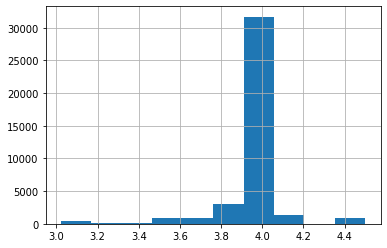

In [ ]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)


In [ ]:
mae = mean_absolute_error(dfValiTarget, test_predicted)

print("Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Average MAE: 0.4370343459618279
analyse_maes.append(0.4370343459618279)


In [ ]:

# print("Run: " + filePrefix)
# # Log of Results
# analyse_maes = []

# print("Average MAE over all tests: " + str(np.mean(analyse_maes)))

# Make sure it's predicting floats
# dfPredicted["Predict"].drop_duplicates()

Write to a subrun file

In [ ]:
dfPredicted = pd.concat([dfValiIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

if writeSubRunFile:
  dfPredicted.to_csv(subrunDir + filePrefix + "_subrun.csv", index=False)

print("Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Average MAE: 0.4370343459618279
(39509, 4)


,RowID,BeerID,ReviewerID,Predict
0,22,12300,2634,3.946275
1,27,12300,5634,3.946275
2,28,12300,3544,3.946275
3,40,12300,6521,3.946275
4,43,12300,10177,3.946275
5,48,12300,2907,3.946275
6,49,12300,1532,3.946275
7,50,12300,3452,3.946275
8,59,12300,6861,3.946275
9,64,6699,6401,3.982681


# Summary

No Param Tuning
* NLP on Beer Name
* MAE: 0.4370343459618279

